**1. Import Libraries**

In [15]:
import time
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Dict, List

from scipy import linalg
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy.linalg import qr

**2. Target-Aware ARS(Adaptive Residual Sampling) QRCP**

In [16]:
# Scikit-Learn Style Class of TAAQ
class TAAQ:
    """
    Target-Aware ARS-QRCP (TAAQ) Feature Selection

    3-Phase Algorithm:
    - Phase 1: QRCP warm-up for k1
    - Phase 2: Target-Projected Residual Sampling (TPRS) with one-step deflation
    - Phase 3: Geometry-Predictive Pruning to size k
    """

    def __init__(self, k: int, k1_fraction: float = 0.5, delta: int = 10,
                epsilon: float = 1e-6, supervised: bool = True):
        self.k = k
        self.k1_fraction = k1_fraction
        self.delta = delta
        self.epsilon = epsilon
        self.supervised = supervised
        self.selected_features_ = None
        self.runtime_ = {}

    def fit(self, M: np.ndarray, y:np.ndarray) -> 'TAAQ':
        """
        Fit TAAQ Selector (Model Trainer)
        """

        # Stamp the start time
        start_time = time.time()

        # Preprocessing
        M_std, y_std = self._preprocess(M, y)
        m, n = M_std.shape

        # Phase1: QRCP warm-up
        t1 = time.time()
        k1 = int(self.k * self.k1_fraction)
        Q1, R11, S1 = self._phase1_qrcp(M_std, k1)
        # Q1, R11, S1 = self._phase1_partial_qrcp(M_std, k1)
        self.runtime_['phase1'] = time.time() - t1

        # Phase2: TPRS (Target-Projected Residual Sampling)
        t2 = time.time()
        S2_prime = self._phase2_tprs(M_std, y_std, Q1, S1, k1, self.delta)
        self.runtime_['phase2'] = time.time() - t2

        # Phase3: GPP (Geometry-Predictive Pruning)
        t3 = time.time()
        S_tmp = np.concatenate([S1, S2_prime])
        S_final = self._phase3_gpp(M_std, y_std, S_tmp, self.k)
        self.runtime_['phase3'] = time.time() - t3

        self.selected_features_ = S_final
        self.runtime_['total'] = time.time() - start_time

        return self

    def _preprocess(self, M: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Standardize columns of M and scale y.
        """
        m, n = M.shape

        # Standardize columns (axis=0): zero mean, unit variance
        M_std = (M - M.mean(axis=0, keepdims=True)) / (M.std(axis=0, keepdims=True) + 1e-10)

        # Center and scale y so that ||y||_2^2 = m
        y_mean = y.mean()
        y_sd = y.std()
        y_std = (y - y_mean) / (y_sd + 1e-10)

        return M_std, y_std

    def _phase1_qrcp(self, M: np.ndarray, k1: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        _, R, piv = linalg.qr(M, mode='economic', pivoting=True)

        S1 = piv[:k1]

        Q1, R11 = linalg.qr(M[:, S1], mode='economic')

        return Q1, R11, S1

    def _phase1_partial_qrcp(self, M: np.ndarray, k1: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Phase 1: Highly optimized Partial QRCP (k1 steps only).

        Complexity: O(m*n*k1)
        """
         
        m, n = M.shape
        
        # Working copy
        A = M.copy()
        
        # perm tracks the original column indices.
        # perm[k] will store the original index of the k-th pivot column.
        perm = np.arange(n)
        
        # Pre-compute the squared L2-norm of each column for pivoting.
        # We use squared norms to avoid sqrt.
        col_norms_full = np.sum(A**2, axis=0)
        col_norms_partial = col_norms_full.copy()
        
        # Storage for the 'tau' scalars needed to reconstruct Q.
        # H_k = I - tau_scalars[k] * v_k * v_k^T
        tau_scalars = np.zeros(k1)

        # main loop
        for k in range(k1):
            
            # ====================
            # 1. COLUMN PIVOTING
            # ====================
            # Find the column with the maximum remaining norm in the sub-array A[k:, k:].
            j_max = k + np.argmax(col_norms_partial[k:])
            
            if j_max != k:
                # Swap the pivot column (j_max) with the current column (k)
                A[:, [k, j_max]] = A[:, [j_max, k]]
                perm[[k, j_max]] = perm[[j_max, k]]
                col_norms_full[[k, j_max]] = col_norms_full[[j_max, k]]
                col_norms_partial[[k, j_max]] = col_norms_partial[[j_max, k]]
            
            # ========================================
            # 2. HOUSEHOLDER QR STEP (on column k)
            # ========================================
            
            # Get the k-th column vector starting from the diagonal.
            x_k = A[k:m, k]
            norm_x_k = np.linalg.norm(x_k)

            if norm_x_k < 1e-14:
                # This column is already (numerically) zero.
                # No reflection needed.
                tau_scalars[k] = 0
                continue
            
            # 'sigma_k' is the target value for the first element,
            # sign((x_k)_1) * ||x_k||.
            sigma_k = -np.sign(x_k[0]) * norm_x_k if x_k[0] != 0 else -norm_x_k
            
            # --- Calculate the LAPACK-style Householder vector 'v' and 'tau' ---
            
            # 1. u_k = x_k - sigma_k * e_1
            u_0 = x_k[0] - sigma_k
            u_tail = x_k[1:]
            
            # 2. tau_k = -u_0 / sigma_k
            tau_k = -u_0 / sigma_k
            tau_scalars[k] = tau_k # Store for Q reconstruction
            
            # 3. v_k = u_k / u_0 = [1, u_tail / u_0]^T
            v_tail = u_tail / u_0 if u_0 != 0 else u_tail # Avoid division by zero

            # Apply the reflection H_k to all remaining columns (k+1 to n)
            # A_sub = (I - tau_k * v_k * v_k^T) @ A_sub
            if k < n - 1:
                A_sub = A[k:m, k+1:n]
                A_sub_head = A_sub[0, :]     # First row of the submatrix
                A_sub_tail = A_sub[1:, :]    # Rest of the submatrix
                
                # w = (v_k^T @ A_sub)
                #   = (v_k[0] * A_sub_head) + (v_tail^T @ A_sub_tail)
                #   = (1 * A_sub_head) + (v_tail^T @ A_sub_tail)
                w = A_sub_head + (v_tail @ A_sub_tail)
                
                # A_sub = A_sub - tau_k * v_k * w^T
                A[k, k+1:n] -= tau_k * w              # Update head (v_k[0]=1)
                A[k+1:m, k+1:n] -= tau_k * np.outer(v_tail, w) # Update tail
            
            # Store R_kk and the Householder vector v_tail
            # directly into the matrix A.
            A[k, k] = sigma_k      # R's diagonal element
            A[k+1:m, k] = v_tail # The tail of the vector v_k
            
            # ===================================
            # 3. UPDATE COLUMN NORMS (downdate)
            # ===================================
            # This is the O(n) part.
            # Use Pythagoras to update the remaining norm of each column after the reflection.
            # new_tail_norm^2 = total_norm^2 - new_head_val^2
            if k < n - 1:
                for j in range(k+1, n):
                    # temp = 1 - (A[k, j] / col_norms_partial[j])**2
                    temp_ratio = A[k, j] / col_norms_partial[j] if col_norms_partial[j] > 0 else 0
                    temp_ratio = max(0, (1 - temp_ratio) * (1 + temp_ratio)) # (1-t^2)
                    
                    # col_norms_partial[j] = col_norms_partial[j] * sqrt(temp_ratio)
                    col_norms_partial[j] *= np.sqrt(temp_ratio)
                    
                    # Failsafe: Recompute norm if numerical error accumulates
                    if col_norms_partial[j] < 0.1 * np.sqrt(col_norms_full[j]):
                        col_norms_partial[j] = np.linalg.norm(A[k+1:m, j])
                        col_norms_full[j] = col_norms_partial[j]**2
        
        # ====================================================================
        # 4. EXTRACT RESULTS (Q, R, S)
        # ====================================================================
        
        # R11 is the upper-triangular k1 x k1 block of A
        R11 = np.triu(A[:k1, :k1])

        Q1 = np.eye(m, k1)
        
        for k in range(k1-1, -1, -1):
            tau_k = tau_scalars[k] # Get the stored scalar
            
            if tau_k != 0:
                # Reconstruct v_k = [1, v_tail]^T
                v = np.zeros(m - k)
                v[0] = 1
                v[1:] = A[k+1:m, k] # Get the stored v_tail
                
                # Apply the transformation:
                # Q1[k:, k:] = H_k @ Q1[k:, k:]
                #            = (I - tau_k * v * v^T) @ Q1[k:, k:]
                w = tau_k * (v @ Q1[k:, k:])
                Q1[k:, k:] -= np.outer(v, w)
        
        # S1: The original indices of the first k1 pivot columns
        S1 = perm[:k1]
        
        return Q1, R11, S1
    
    def _phase2_tprs(self, M: np.ndarray, y: np.ndarray, Q1: np.ndarray,
                    S1: np.ndarray, k1: int, delta: int) -> np.ndarray:
        """
        Phase 2: Target-Projected Residual Sampling with one-step 
        """
        m, n = M.shape
        k2 = self.k - k1
        # ==========
        # 1. TPRS
        # ==========
        # Target residual
        r_y = y - Q1 @ (Q1.T @ y)

        # Precompute residualized features
        Q1_T_M = Q1.T @ M

        # b_j = \|x_j\|_2^2 - \|Q_1^Tx_j\|_2^2
        b = np.sum(M**2, axis=0) - np.sum(Q1_T_M**2, axis=0)
        b = np.maximum(b, self.epsilon) # Prevent 0

        # s_j = r_y^TP_\perpx_j = r_y^Tx_j
        s = r_y @ M

        # Supervised score a_j := s_j^2 / (b_j + \epsilon)
        if self.supervised:
            a = s**2 / (b + self.epsilon)
        else:
            a = b
        # ==================================================
        # 2. Greedy Oversampling with one-step deflation
        # ==================================================
                
        # Initialize candidate pool
        valid_mask = np.ones(n, dtype=bool)
        valid_mask[S1] = False

        # List for chosen columns in phase 2
        S2_prime = []

        for _ in range(k2+delta):
            a_masked = np.where(valid_mask, a, -np.inf)

            # j* = argmax a_j
            j_star = np.argmax(a_masked)

            # Add it to the answer
            S2_prime.append(j_star)

            # Update for the next iteration
            valid_mask[j_star] = False

            # ----- One-Step Deflation ----- #

            # Choose the column for the chosen j
            x_j = M[:, j_star]

            # Get P_\perp x_j
            P_perp_x = x_j - Q1 @ (Q1.T @ x_j)

            # Normalize it
            norm_P_perp_x = np.linalg.norm(P_perp_x)

            if norm_P_perp_x > 1e-10:

                # New direction (contribution) of x_j
                u = P_perp_x / norm_P_perp_x

                # The Magnitude * direction = The new contribution of x_j
                g = u.T @ M

                # The new columns contribution to the label
                alpha = u.T @ r_y

                # Decrease the residual
                r_y -= alpha * u

                # Decrease the correlation of each columns
                s -= alpha * g

                if self.supervised:
                    a = s**2 / (b+self.epsilon)

                else:
                    a = b     

        return np.array(S2_prime, dtype=int)

    def _phase3_gpp(self, M: np.ndarray, y: np.ndarray,
                   S_tmp: np.ndarray, k:int) -> np.ndarray:
        """
        Phase 3: Geometry-Predictive Pruning to size k.
        """
        # Working copy
        S_current = S_tmp.copy()

        # Measure delta that we are going to prune
        delta = len(S_tmp) - k

        for _ in range(delta):
            C = M[:, S_current]

            # QR Decomposition
            # mode='economic' --> thin QR (Q = m*n, R = n*n)
            Q, R = linalg.qr(C, mode='economic')

            # Compute beta (R^-1(Q^T y)) --> "Predictive"
            # We don't get inverse, we use "back substitution" (solve_triangular)
            # \beta = min\|C\beta-y\|_2^2
            # Least Square Problem
            # Equation: C\beta = y
            # Solution: \beta = (C^TC)^-1C^Ty
            # \beta = (R^TQ^TQ^R)^-1R^TQ^Ty = (R^TR)^-1R^TQ^Ty = R^-1Q^Ty
            beta = linalg.solve_triangular(R, Q.T @ y, lower=False)

            # Compute r_i --> "Geometric Redundancy" (Numerical Instability)
            # VIF (Variance Inflaction Factor) = 1/ (1 - R_i)
            # C = QR --> G = C^TC = R^TR
            # r_i = \|R^-Te_i\|_2^2 = (R^-Te_i)^T(R^-Te_i) = e_i^T(R^-1R^-T)e_i = e_i^T(R^TR)^-1e_i = [(C^TC)^-1]_ii
            # By block matrix inversion --> (G^-1)_ii = 1 / c_i^Tc_i(1-R_i^2) = 1/\|c_i\|_2^2 \times VIF_i
            R_inv_T = linalg.solve_triangular(R, np.eye(len(S_current)), trans='T', lower=False)
            r_i = np.sum(R_inv_T**2, axis=0)

            # Compute drop scores: d_i = r_i / (beta_i^2 + epsilon)
            d_i = r_i / (beta**2 + self.epsilon)

            # Remove worst feature
            i_star = np.argmax(d_i)
            S_current = np.delete(S_current, i_star) # Delete the column

        return S_current
        
    def transform(self, M: np.ndarray) -> np.ndarray:
        """
        Select features from M.
        """
        
        if self.selected_features_ is None:
            raise ValueError("Must fit before transform")
            
        return M[:, self.selected_features_]  
        
    def fit_transform(self, M: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Fit and transform in one step.
        """
        return self.fit(M, y).transform(M)

**3. Baseline Methods**

In [17]:
from scipy.linalg import qr
class QRCP:
    """
    QR Decomposition with Column Pivoting (QRCP) 

    Produces a weak rank-revealing decomposition:
        X[:, P] = Q @ R
    where:
        - Q is orthogonal
        - R is upper-triangular
        - P is a permutation array (pivot indices)
    
    Can select the top-k columns based on pivoting.
    """

    def __init__(self, top_k: int = None):
        """
        Parameters
        ----------
        top_k : int, optional
            Number of top features (columns) to select. If None, select all.
        """
        self.top_k = top_k                # Target number of features
        self.Q = None                     # Orthogonal matrix from QR
        self.R = None                     # Upper-triangular matrix from QR
        self.P = None                     # Column permutation indices
        self.selected_features_ = None    # Indices of top-selected features
        self.runtime_ = {}                # Dictionary to track runtimes

    def fit(self, X: np.ndarray, y=None) -> 'QRCP':
        """
        Fit the QRCP model to the data X.

        Parameters
        ----------
        X : np.ndarray, shape (m, n)
            Input feature matrix
        y : ignored
            Included for API compatibility with supervised methods.

        Returns
        -------
        self : QRCP
            Fitted object with Q, R, P, and selected_features_ populated.
        """
        start_time = time.time()

        # STEP 1: Compute QR decomposition with column pivoting
        t_qr_start = time.time()
        Q, R, piv = qr(X, pivoting=True, mode='economic')
        self.runtime_['qr_decomposition'] = time.time() - t_qr_start

        # Store decomposition results
        self.Q = Q
        self.R = R
        self.P = np.array(piv)

        # STEP 2: Determine selected features (top-k pivoted columns)
        n_features = X.shape[1]
        k = self.top_k if self.top_k is not None else n_features
        self.selected_features_ = self.P[:k]

        # Record total runtime
        self.runtime_['total'] = time.time() - start_time

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform X by selecting the top-k pivoted columns.
        """
        if self.selected_features_ is None:
            raise ValueError("Must call fit() before transform()")
        return X[:, self.selected_features_]

    def fit_transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        Convenience method to fit and transform in one step.

        """
        return self.fit(X, y).transform(X)

**4. Evaluation Framework (Metric, Plotting, Tracks)** 

In [18]:
def bar_plot(scores: Dict[str, float], title: str, ylabel: str):
    labels = list(scores.keys())
    vals = [scores[k] for k in labels]
    plt.figure()
    plt.title(title)
    plt.bar(labels, vals)
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

def run_supervised_track(X: np.ndarray, y: np.ndarray, k: int, n_splits: int = 3):
    print("\n" + "="*68)
    print("TRACK A — SUPERVISED  (TAAQ  vs  QRCP)")
    print("="*68)

    Xs = StandardScaler().fit_transform(X)
    ys = (y - y.mean()) / (y.std() + 1e-12)

    methods = {
        "TAAQ": TAAQ(k=k, k1_fraction=0.5, delta=10, supervised=True),
        "QRCP": QRCP(top_k=k), 
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rows = []
        Xtr, Xte = Xs[tr], Xs[te]
        ytr, yte = ys[tr], ys[te]
        print(f"\n  Fold {fold+1}/{n_splits}")
        for name, meth in methods.items():
            t = time.time()
            if isinstance(meth, TAAQ):
                meth.fit(Xtr, ytr)
            else:
                meth.fit(Xtr, ytr)
            S = meth.selected_features_
            # Ridge on selected features (held-out test)
            mdl = Ridge(alpha=1.0).fit(Xtr[:, S], ytr)
            y_pred = mdl.predict(Xte[:, S])
            r2 = r2_score(yte, y_pred)
            rmse = float(np.sqrt(mean_squared_error(yte, y_pred)))
            runtime = time.time() - t
            rows.append(dict(method=name, fold=fold, r2=r2, rmse=rmse, runtime=runtime, k=len(S)))
            print(f"    - {name:6s} | R²={r2: .3f} | RMSE={rmse: .3f} | k={len(S)}")

    df = pd.DataFrame(rows)
    summ = df.groupby("method")[["r2", "rmse", "runtime"]].mean().round(4)
    print("\nSupervised summary (mean over folds):\n", summ)

    bar_plot(summ["r2"].to_dict(), "Supervised: R² (higher is better)", "R²")
    bar_plot(summ["rmse"].to_dict(), "Supervised: RMSE (lower is better)", "RMSE")
    bar_plot(summ["runtime"].to_dict(), "Supervised: Runtime (s)", "seconds")

    return df

IndentationError: unexpected indent (1012806676.py, line 27)

**5. Data Generators**

In [ ]:
def dataset_synthetic(m=350, n=120, k_true=25, noise=10, seed=42):
    X, y = make_regression(n_samples=m, n_features=n, n_informative=k_true,
                           noise=noise, random_state=seed)
    return X, y

**6. Experiments**

In [ ]:
def main():
    print("\n" + "="*80)
    print("TAAQ MINIMAL EXPERIMENTS")
    print("="*80)

    # 1) Synthetic: both tracks
    print("\n[Dataset] Synthetic linear (m=350, n=120)")
    Xs, ys = dataset_synthetic()
    k = 35
    run_supervised_track(Xs, ys, k=k, n_splits=3)

    print("\nAll done.")

**7. Quick Test**

**8. Main Execution**


TAAQ MINIMAL EXPERIMENTS

[Dataset] Synthetic linear (m=350, n=120)

TRACK A — SUPERVISED  (TAAQ  vs  QRCP)

  Fold 1/3
    - TAAQ   | R²= 0.997 | RMSE= 0.051 | k=35
    - QRCP   | R²= 0.132 | RMSE= 0.910 | k=35

  Fold 2/3
    - TAAQ   | R²= 0.998 | RMSE= 0.043 | k=35
    - QRCP   | R²= 0.105 | RMSE= 0.929 | k=35

  Fold 3/3
    - TAAQ   | R²= 0.998 | RMSE= 0.041 | k=35
    - QRCP   | R²= 0.121 | RMSE= 0.965 | k=35

Supervised summary (mean over folds):
             r2    rmse  runtime
method                         
QRCP    0.1194  0.9348    0.010
TAAQ    0.9979  0.0453    0.036


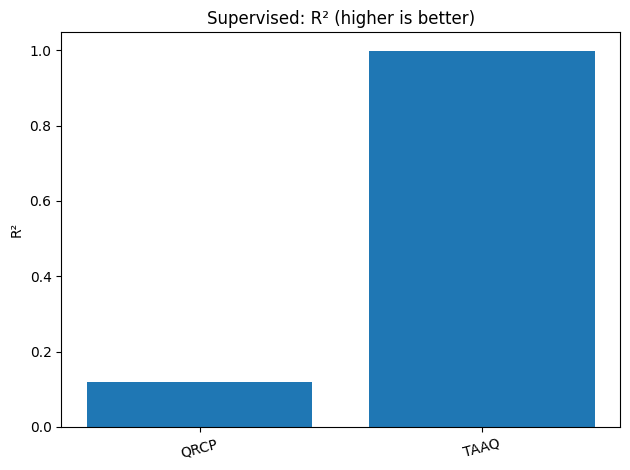

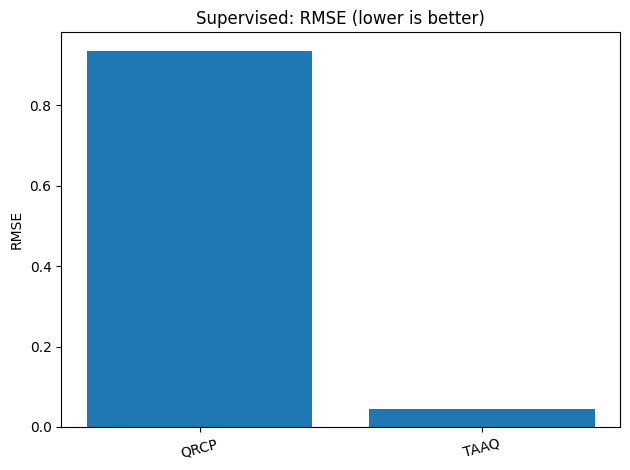

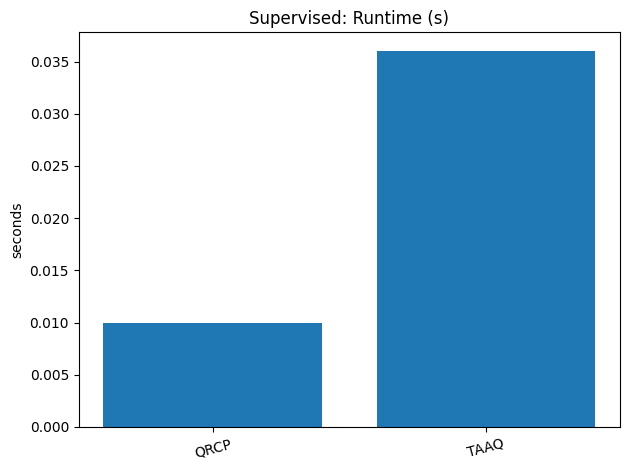


All done.


In [ ]:
if __name__ == "__main__":
    main()